In [589]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

In [590]:
df = pd.read_csv('orders.csv')

In [591]:
df = df.drop(columns = ['Unnamed: 0'],axis = 1).sort_values('order_id')

In [592]:
df.head()

,order_id,date,user_id,order_type,value,address_id
0,252352321,2019-01-01,1007518,call,19.5,398532
8,252352322,2019-01-01,1002867,app,18.5,398533
16,252352323,2019-01-01,1012580,app,35.5,398534
21,252352324,2019-01-01,1014338,app,9.5,398535
30,252352325,2019-01-01,1002539,app,24.5,398536


In [593]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113117 entries, 0 to 71447
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   order_id    113117 non-null  int64  
 1   date        113117 non-null  object 
 2   user_id     113117 non-null  int64  
 3   order_type  113117 non-null  object 
 4   value       113117 non-null  float64
 5   address_id  113117 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 6.0+ MB


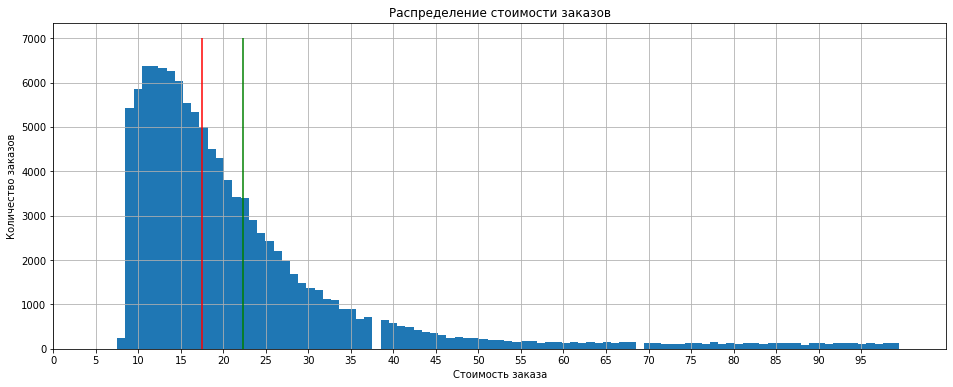

In [594]:
plt.figure(figsize=(16, 6))


df['value'].hist(bins = 95)
x_ticks = np.arange(0,100,5)
plt.xlim(0,105)
plt.title('Распределение стоимости заказов')
plt.xlabel("Стоимость заказа")
plt.ylabel("Количество заказов")
plt.xticks(x_ticks)
plt.vlines(df['value'].mean(), 0, 7000, color = 'g')
plt.vlines(df['value'].median(), 0, 7000, color = 'r')

plt.show()

In [595]:
print('Количество уникальных клиентов:',df['user_id'].nunique())
print('Количество уникальных способов доставки:',df['order_type'].nunique())
print('Все способы заказа доставки:',df['order_type'].unique())
print('Количество уникальных адресов:',df['address_id'].nunique())
print("Количество дубликатов", df.duplicated().sum())

Количество уникальных клиентов: 14994
Количество уникальных способов доставки: 3
Все способы заказа доставки: ['call' 'app' 'web']
Количество уникальных адресов: 14994
Количество дубликатов 0


In [596]:
df['value'].describe()

count    113117.000000
mean         22.272528
std          15.783137
min           7.500000
25%          12.500000
50%          17.500000
75%          25.500000
max          99.500000
Name: value, dtype: float64

In [597]:
print('Самая ранняя дата: ', df['date'].min())
print('Самая поздняя дата: ', df['date'].max())

Самая ранняя дата:  2019-01-01
Самая поздняя дата:  2019-08-31


In [598]:
avg_rate = (62.941 + 63.8653 + 64.3559 + 64.9874 + 65.5325 + 63.1991 + 64.2314 + 64.816 +  64.6193 + 65.1476 + 65.8605 + 67.3473)/12

In [599]:
df['value'] = round(df['value'] * avg_rate)

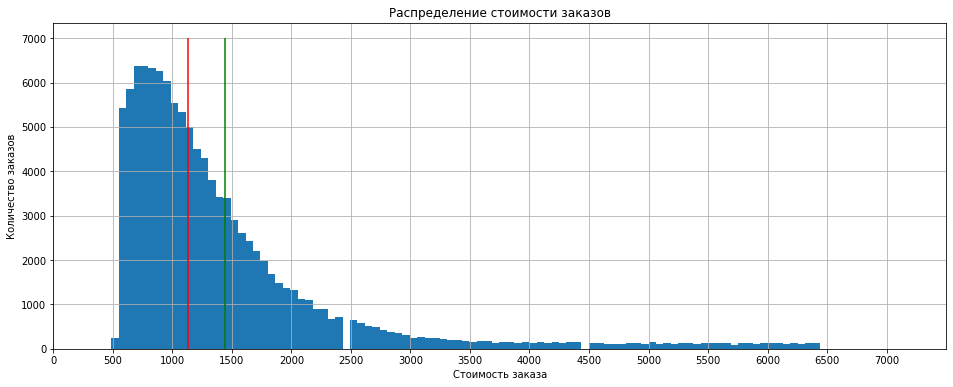

In [600]:
plt.figure(figsize=(16, 6))


df['value'].hist(bins = 95)
x_ticks = np.arange(0,7500,500)
plt.xlim(0,7500)
plt.title('Распределение стоимости заказов')
plt.xlabel("Стоимость заказа")
plt.ylabel("Количество заказов")
plt.xticks(x_ticks)
plt.vlines(df['value'].mean(), 0, 7000, color = 'g')
plt.vlines(df['value'].median(), 0, 7000, color = 'r')

plt.show()

In [601]:
round(df['value'].describe())

count    113117.0
mean       1442.0
std        1022.0
min         486.0
25%         809.0
50%        1133.0
75%        1651.0
max        6442.0
Name: value, dtype: float64

In [602]:
frequency = df.groupby('user_id')['order_id'].count()
frequency = frequency.reset_index().sort_values(by = 'order_id',  ascending= False)
frequency

,user_id,order_id
6255,1006257,19
12314,1012318,19
39,1000039,18
14263,1014268,18
13734,1013739,18
...,...,...
8480,1008482,1
7173,1007175,1
3186,1003187,1
10251,1010255,1


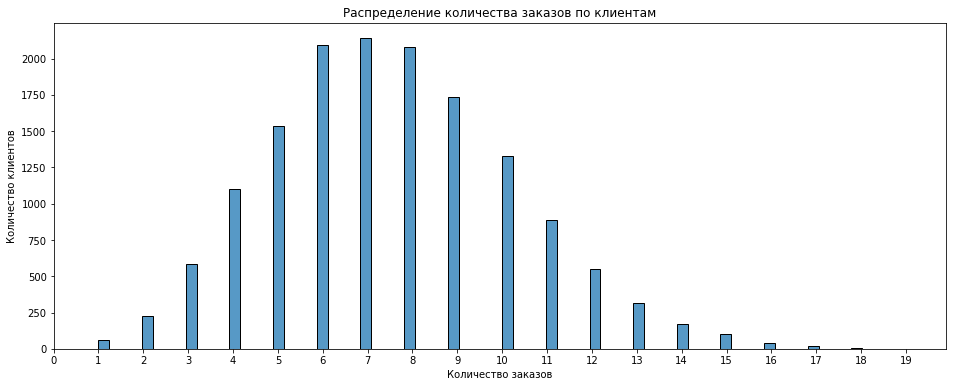

In [603]:
plt.figure(figsize=(16, 6))


x_ticks = np.arange(0,20,1)

sns.histplot(frequency['order_id'])

plt.xticks(x_ticks)

plt.title('Распределение количества заказов по клиентам')
plt.xlabel("Количество заказов")
plt.ylabel("Количество клиентов")
plt.show()

In [604]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['date_difference'] = max(df['date']) - df['date']

In [605]:
recency = df.groupby('user_id')['date_difference'].min()
recency = recency.reset_index()
recency

,user_id,date_difference
0,1000000,22 days
1,1000001,45 days
2,1000002,48 days
3,1000003,15 days
4,1000004,25 days
...,...,...
14989,1014995,29 days
14990,1014996,20 days
14991,1014997,16 days
14992,1014998,15 days


In [606]:
monetary = df.groupby('user_id').agg({'value': 'sum'}).\
    reset_index().rename(columns={'value':'monetary'})

monetary

,user_id,monetary
0,1000000,15701.0
1,1000001,5276.0
2,1000002,4305.0
3,1000003,12011.0
4,1000004,14827.0
...,...,...
14989,1014995,12399.0
14990,1014996,9548.0
14991,1014997,12496.0
14992,1014998,12171.0


In [607]:
rfm = pd.merge(recency,frequency, on ='user_id', how = 'inner')

In [608]:
rfm = pd.merge(rfm, monetary, on ='user_id', how = 'inner')

In [609]:
rfm.columns = ['user_id','recency', 'frequency', 'monetary']

In [610]:
rfm['recency'] = rfm['recency'].dt.days

In [611]:
rfm.head(10)

,user_id,recency,frequency,monetary
0,1000000,22,11,15701.0
1,1000001,45,5,5276.0
2,1000002,48,5,4305.0
3,1000003,15,7,12011.0
4,1000004,25,12,14827.0
5,1000005,20,9,18806.0
6,1000006,37,4,4662.0
7,1000007,20,9,11621.0
8,1000008,60,6,7187.0
9,1000009,6,9,11362.0


In [612]:
quantiles = rfm.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [613]:
quantiles 

{'user_id': {0.25: 1003749.25, 0.5: 1007498.5, 0.75: 1011248.75},
 'recency': {0.25: 9.0, 0.5: 22.0, 0.75: 45.0},
 'frequency': {0.25: 6.0, 0.5: 7.0, 0.75: 9.0},
 'monetary': {0.25: 7413.0, 0.5: 10327.0, 0.75: 13790.75}}

In [614]:
def RScore(x,metric,quantiles):
    if x <= quantiles[metric][0.25]:
        return 4
    elif x <= quantiles[metric][0.5]:
        return 3
    elif x <= quantiles[metric][0.75]:
        return 2
    else:
        return 1

In [615]:
def FMScore(x,metric,quantiles):
    if x <= quantiles[metric][0.25]:
        return 1
    elif x<= quantiles[metric][0.5]:
        return 2
    elif x <= quantiles[metric][0.75]:
        return 3
    else:
        return 4

In [616]:
rfm['R_quartile'] = rfm['recency'].apply(RScore, args=('recency',quantiles))
rfm['F_quartile'] = rfm['frequency'].apply(RScore, args=('frequency',quantiles))
rfm['M_quartile'] = rfm['monetary'].apply(RScore, args=('monetary',quantiles))

In [617]:
rfm['RFM_Segment'] = rfm.R_quartile.map(str)+rfm.F_quartile.map(str)+rfm.M_quartile.map(str)
rfm['RFM_Score'] = rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [618]:
rfm

,user_id,recency,frequency,monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,1000000,22,11,15701.0,3,1,1,311,5
1,1000001,45,5,5276.0,2,4,4,244,10
2,1000002,48,5,4305.0,1,4,4,144,9
3,1000003,15,7,12011.0,3,3,2,332,8
4,1000004,25,12,14827.0,2,1,1,211,4
...,...,...,...,...,...,...,...,...,...
14989,1014995,29,9,12399.0,2,2,2,222,6
14990,1014996,20,7,9548.0,3,3,3,333,9
14991,1014997,16,6,12496.0,3,4,2,342,9
14992,1014998,15,10,12171.0,3,1,2,312,6


In [619]:
rfm['RFM_Segment'].nunique()

61

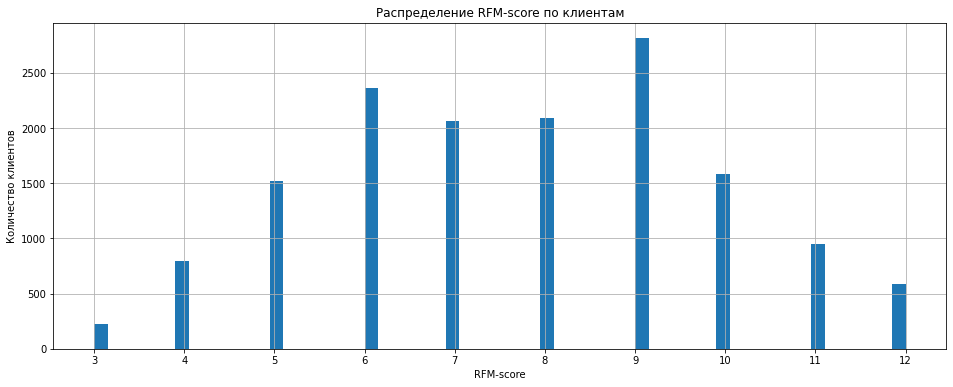

In [620]:
plt.figure(figsize=(16, 6))

rfm['RFM_Score'].hist(bins = 60)

plt.title('Распределение RFM-score по клиентам')
plt.xlabel("RFM-score")
plt.ylabel("Количество клиентов")
plt.xticks(list(rfm['RFM_Score'].unique()))

plt.show()

In [621]:
print('Лучшие покупатели: ', len(rfm[rfm['RFM_Segment'] == '444']), "| доля: ",
     round(len(rfm[rfm['RFM_Segment'] == '444'])/len(rfm),2))
print('Лояльные покупатели: ', len(rfm[rfm['F_quartile'] == 4]), "| доля: ", 
      round(len(rfm[rfm['F_quartile'] == 4])/len(rfm),2))
print('Большой кошелек: ', len(rfm[rfm['M_quartile'] == 4]), "| доля: ", 
      round(len(rfm[rfm['M_quartile'] == 4])/len(rfm),2))
print('На грани оттока: ', len(rfm[rfm['R_quartile'] == 1]), "| доля: ", 
      round(len(rfm[rfm['R_quartile'] == 1])/len(rfm),2))
print('Наименее привлекательные клиенты: ', len(rfm[rfm['RFM_Segment'] == '111']), "| доля: ",
      round(len(rfm[rfm['RFM_Segment'] == '111'])/len(rfm),2))

Лучшие покупатели:  584 | доля:  0.04
Лояльные покупатели:  5604 | доля:  0.37
Большой кошелек:  3774 | доля:  0.25
На грани оттока:  3659 | доля:  0.24
Наименее привлекательные клиенты:  225 | доля:  0.02


In [622]:
rfm[rfm['recency'] == 0]

,user_id,recency,frequency,monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
20,1000020,0,6,7251.0,4,4,4,444,12
74,1000074,0,10,10617.0,4,1,2,412,7
77,1000077,0,6,10876.0,4,4,2,442,10
100,1000100,0,7,11167.0,4,3,2,432,9
166,1000166,0,7,9031.0,4,3,3,433,10
171,1000171,0,7,7543.0,4,3,3,433,10
173,1000173,0,9,12397.0,4,2,2,422,8
184,1000184,0,6,9517.0,4,4,3,443,11
195,1000195,0,14,19229.0,4,1,1,411,6
208,1000208,0,5,6507.0,4,4,4,444,12


In [623]:
rfm['recency'] = rfm['recency'].replace(0,1)

In [624]:
rfm[rfm['recency'] == 0]

,user_id,recency,frequency,monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score


In [625]:
rfm['recency'].describe()

count    14994.000000
mean        31.819061
std         31.923214
min          1.000000
25%          9.000000
50%         22.000000
75%         45.000000
max        237.000000
Name: recency, dtype: float64

In [626]:
rfm

,user_id,recency,frequency,monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,1000000,22,11,15701.0,3,1,1,311,5
1,1000001,45,5,5276.0,2,4,4,244,10
2,1000002,48,5,4305.0,1,4,4,144,9
3,1000003,15,7,12011.0,3,3,2,332,8
4,1000004,25,12,14827.0,2,1,1,211,4
...,...,...,...,...,...,...,...,...,...
14989,1014995,29,9,12399.0,2,2,2,222,6
14990,1014996,20,7,9548.0,3,3,3,333,9
14991,1014997,16,6,12496.0,3,4,2,342,9
14992,1014998,15,10,12171.0,3,1,2,312,6


In [627]:
def visualisation_distribution(df):
    fig, axes = plt.subplots(3, 1, figsize=(10,10))
    
    sns.distplot(a= df['recency'], ax=axes[0])
    sns.distplot(a = df['frequency'] ,  ax=axes[1])
    sns.distplot(a= df['monetary'],  ax=axes[2])
    fig.tight_layout()

In [628]:
rfm = rfm[['user_id','recency', 'frequency', 'monetary']]

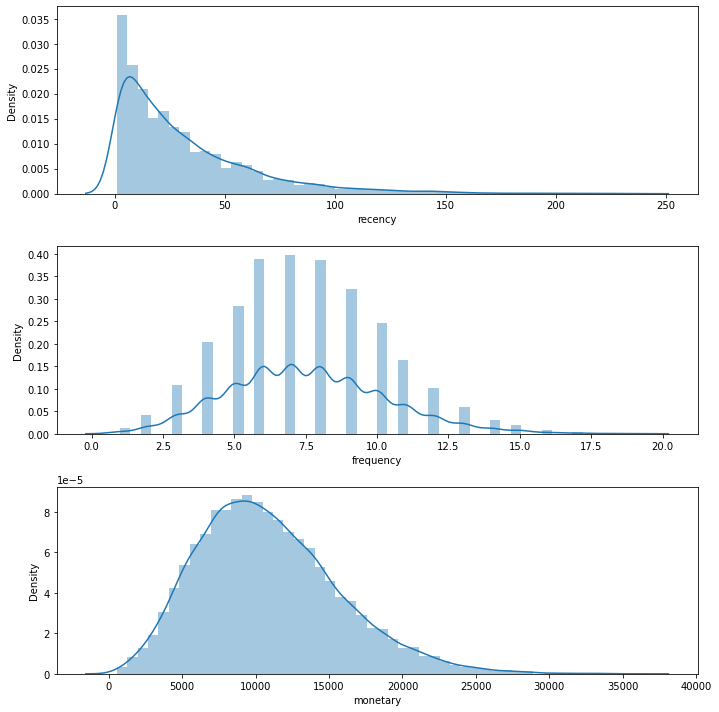

In [629]:
visualisation_distribution(rfm)

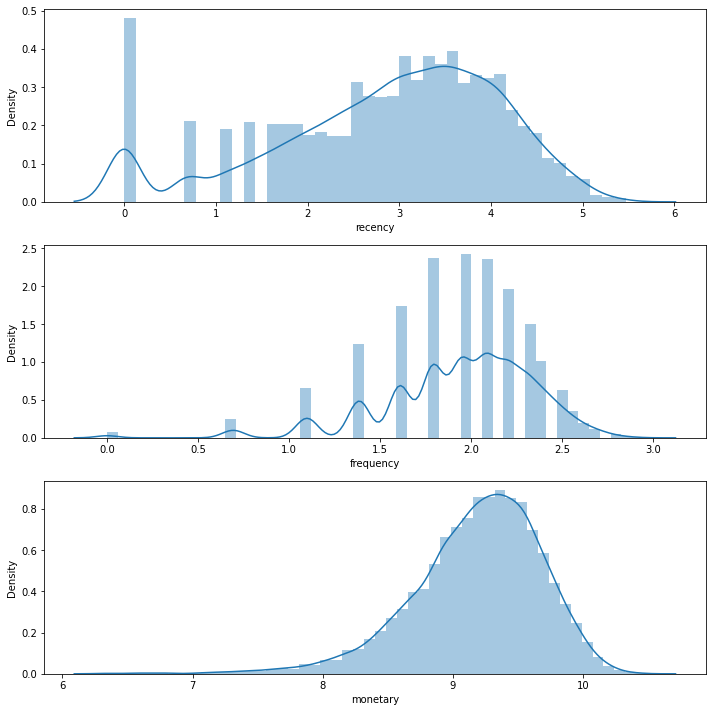

In [630]:
df_rfm_log = np.log(rfm[['recency', 'frequency', 'monetary']])

visualisation_distribution(df_rfm_log)

In [631]:
df_rfm_log

,recency,frequency,monetary
0,3.091042,2.397895,9.661480
1,3.806662,1.609438,8.570924
2,3.871201,1.609438,8.367532
3,2.708050,1.945910,9.393578
4,3.218876,2.484907,9.604205
...,...,...,...
14989,3.367296,2.197225,9.425371
14990,2.995732,1.945910,9.164087
14991,2.772589,1.791759,9.433164
14992,2.708050,2.302585,9.406811


In [632]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = pd.DataFrame(scaler.transform(df_rfm_log))
RFM_Table_scaled.columns = ['recency', 'frequency', 'monetary']

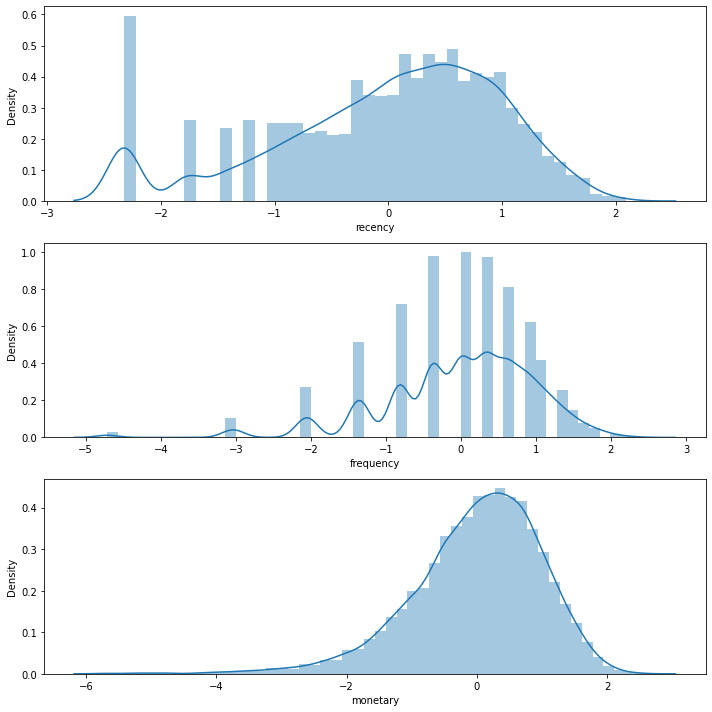

In [633]:
visualisation_distribution(RFM_Table_scaled)

# Elbow method

In [634]:
distortions= []
range_n_clusters = range(2,17)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(RFM_Table_scaled)

    distortions.append(kmeans.inertia_)

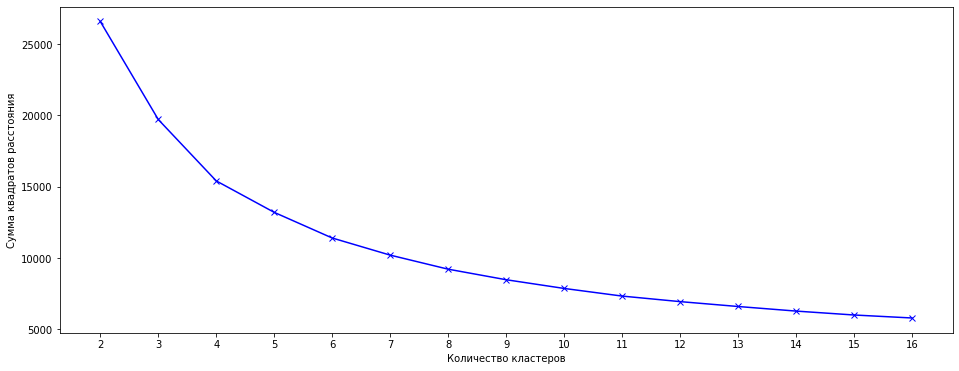

In [635]:
plt.figure(figsize=(16, 6))

plt.plot(range_n_clusters, ssd, 'bx-') 
plt.xticks(range_n_clusters)
plt.xlabel("Количество кластеров")
plt.ylabel("Сумма квадратов расстояния")
plt.show()

# Silhouette Analysis

In [636]:
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter =50)
    kmeans.fit(RFM_Table_scaled )
    cluster_labels = kmeans.fit_predict(RFM_Table_scaled )
    
    silhouette_avg = silhouette_score(RFM_Table_scaled , cluster_labels)
    print('Для n_clusters = {0}, оценка силуэта будет {1}'.format(num_clusters, silhouette_avg))

Для n_clusters = 2, оценка силуэта будет 0.36714318493905684
Для n_clusters = 3, оценка силуэта будет 0.3292486233192915
Для n_clusters = 4, оценка силуэта будет 0.3139472442404476
Для n_clusters = 5, оценка силуэта будет 0.3065883156598802
Для n_clusters = 6, оценка силуэта будет 0.2825072218944273
Для n_clusters = 7, оценка силуэта будет 0.2879400907653151
Для n_clusters = 8, оценка силуэта будет 0.27585832050329984
Для n_clusters = 9, оценка силуэта будет 0.2760438298362781
Для n_clusters = 10, оценка силуэта будет 0.2701509612718791
Для n_clusters = 11, оценка силуэта будет 0.2593999124632077
Для n_clusters = 12, оценка силуэта будет 0.2568763816035962
Для n_clusters = 13, оценка силуэта будет 0.2511309780153576
Для n_clusters = 14, оценка силуэта будет 0.24821403561530972
Для n_clusters = 15, оценка силуэта будет 0.24868899328764935
Для n_clusters = 16, оценка силуэта будет 0.24604062363724566


In [637]:
def kmeans_model(data_norm, n_clusters):

    kmeans= KMeans(n_clusters= n_clusters, max_iter = 50 ,random_state = 3)
    kmeans.fit(data_norm)
    y_kmeans = kmeans.predict(data_norm)
    
    fig, axes = plt.subplots(3, 1, figsize=(10,10))
    
    sns.scatterplot(x = data_norm['monetary'], y = data_norm['recency'], c=y_kmeans , ax=axes[0]).\
                            set(title='Recency VS Monetary для {} кластеров'.format(n_clusters))
    sns.scatterplot(x = data_norm['monetary'], y =  data_norm['frequency'], c=y_kmeans, ax=axes[1]).\
                            set(title='Frequency VS Monetary для {} кластеров'.format(n_clusters))
    sns.scatterplot(x = data_norm['recency'], y = data_norm['frequency'], c=y_kmeans, ax=axes[2]).\
                            set(title='Frequency VS Recency для {} кластеров'.format(n_clusters))
    fig.tight_layout()

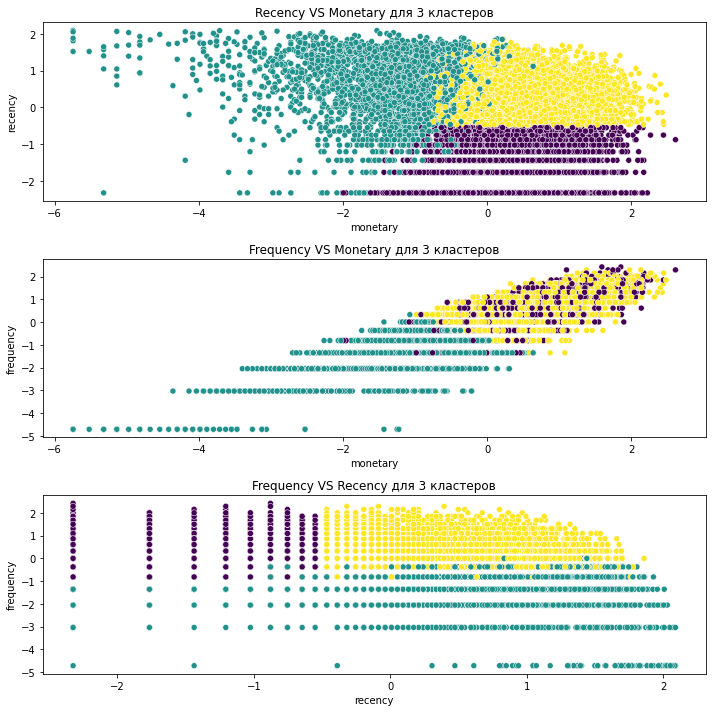

In [638]:
kmeans_model(RFM_Table_scaled,3)

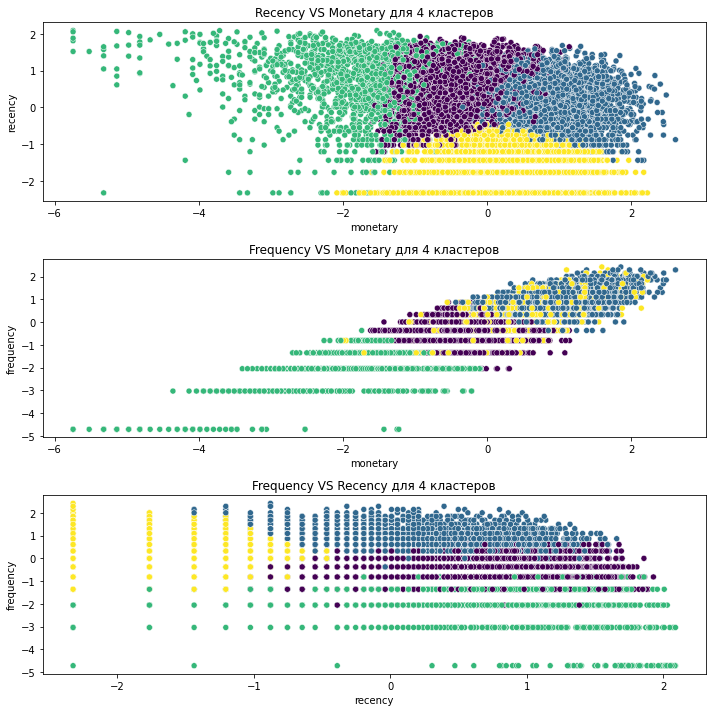

In [639]:
kmeans_model(RFM_Table_scaled,4)

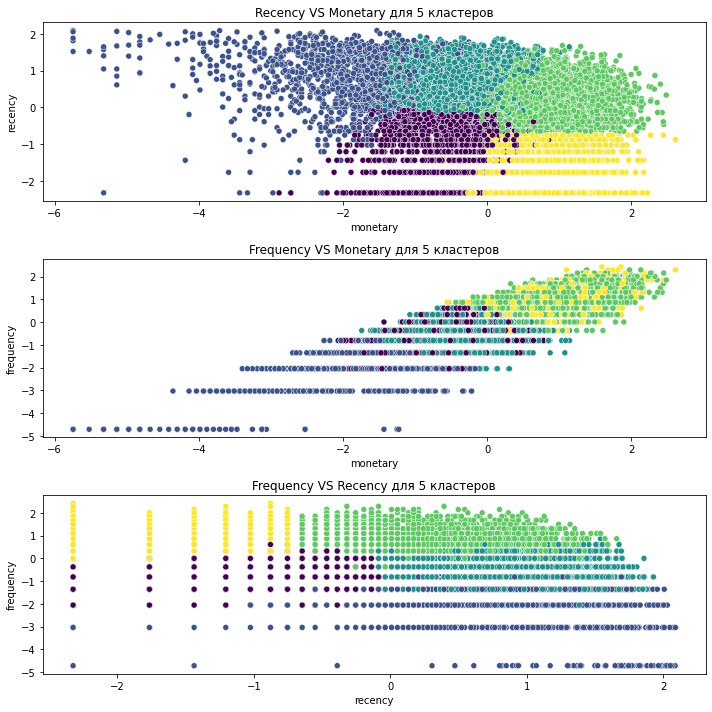

In [640]:
kmeans_model(RFM_Table_scaled,5)

In [641]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, max_iter = 50)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_ + 1
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Cглаженный график для {} кластеров'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

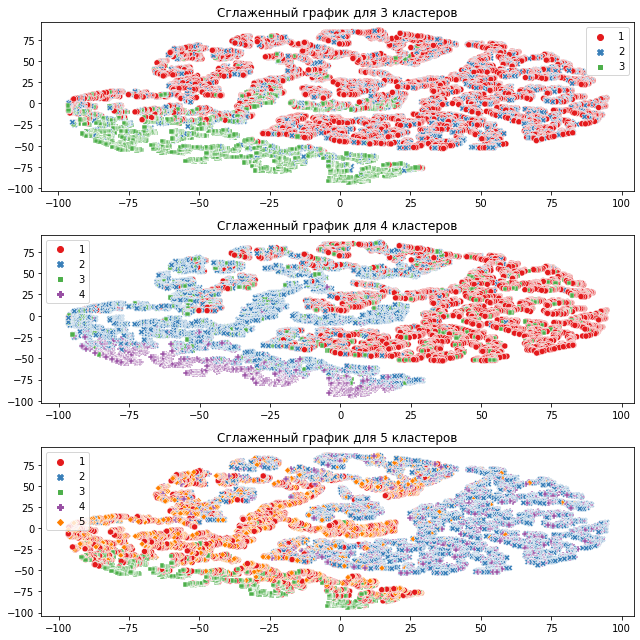

In [642]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled[['recency','frequency','monetary']], 3, rfm)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled[['recency','frequency','monetary']], 4, rfm)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled[['recency','frequency','monetary']], 5, rfm)

plt.tight_layout()

In [643]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm_original.index, 
                                       columns=df_rfm_original.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']
    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['user_id', 'Cluster'],
                        value_vars=['recency', 'frequency', 'monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

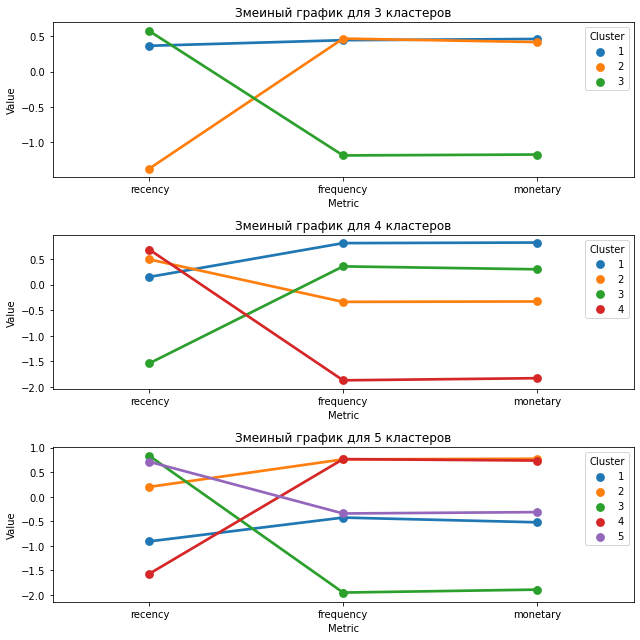

In [644]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Змеиный график для 3 кластеров')
snake_plot(RFM_Table_scaled, df_rfm_k3, rfm)

plt.subplot(3, 1, 2)
plt.title('Змеиный график для 4 кластеров')
snake_plot(RFM_Table_scaled, df_rfm_k4, rfm)

plt.subplot(3, 1, 3)
plt.title('Змеиный график для 5 кластеров')
snake_plot(RFM_Table_scaled, df_rfm_k5, rfm)

plt.tight_layout()

In [645]:
df_rfm_k4.head(10)

,user_id,recency,frequency,monetary,Cluster
0,1000000,22,11,15701.0,1
1,1000001,45,5,5276.0,2
2,1000002,48,5,4305.0,4
3,1000003,15,7,12011.0,1
4,1000004,25,12,14827.0,1
5,1000005,20,9,18806.0,1
6,1000006,37,4,4662.0,4
7,1000007,20,9,11621.0,1
8,1000008,60,6,7187.0,2
9,1000009,6,9,11362.0,3


In [646]:
def adding_avg_check(df):
    df['avg_check'] = df['monetary'] / df['frequency']
    return df

In [647]:
df_rfm_k4 = adding_avg_check(df_rfm_k4)

In [648]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': ['mean', 'count'],
        'avg_check': 'mean'
    }).round(0)
    return df_new

In [649]:
rfm_values(df_rfm_k4)

recency frequency monetary       avg_check
           mean      mean     mean count      mean
Cluster                                           
1          27.0      10.0  15143.0  4931    1543.0
2          42.0       6.0   8503.0  5356    1407.0
3           3.0       8.0  11984.0  2970    1439.0
4          62.0       3.0   4207.0  1737    1281.0